# Zero-shot evaluation of Gemini Pro


In [ ]:
#@title Configure Gemini API key

from google.colab import userdata

#Access your Gemini API key

!pip install -q -U google-generativeai
import google.generativeai as genai
from google.colab import userdata

try:
  GOOGLE_API_KEY=userdata.get('gemini_api_secret_name')
  genai.configure(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError as e:
   print(f'''Secret not found

This expects you to create a secret named {gemini_api_secret_name} in Colab

Visit https://makersuite.google.com/app/apikey to create an API key

Store that in the secrets section on the left side of the notebook (key icon)

Name the secret {gemini_api_secret_name}''')
   raise e
except userdata.NotebookAccessError as e:
  print(f'''You need to grant this notebook access to the {gemini_api_secret_name} secret in order for the notebook to access Gemini on your behalf.''')
  raise e
except Exception as e:
  # unknown error
  print(f"There was an unknown error. Ensure you have a secret {gemini_api_secret_name} stored in Colab and it's a valid key from https://makersuite.google.com/app/apikey")
  raise e

model = genai.GenerativeModel('gemini-pro')

## Load dataset

In [ ]:
import pandas as pd

df = pd.read_csv('ipcc_statements_dataset.tsv', sep='\t')
df.columns = ['statement_idx', 'report', 'page_num', 'sent_num', 'statement', 'confidence', 'score', 'split']

df['prediction'] = ""

train_set = df.loc[df['split'] == 'train']
test_set = df.loc[df['split'] == 'test']

In [ ]:
#@title Use Gemini Pro to relabel the dataset

for i in range(len(test_set)):
    row = test_set.iloc[i]

    prompt = "You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.\n\nYou will be presented with a statement about climate science, climate impacts or cli mate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?\n\nRespond *only* with one of the following words: ’low’, ’medium’, ’high’, ’very high’. If you don’t know, you can respond ’I don’t know’.\n—\nFollow the following format.\nStatement: ${a short statement about climate.}\nConfidence: ${must be *only*: ’low’, ’medium’, ’high’, ’very high’}\n—\nStatement: %s\nConfidence: " % (row[4])

    completion = response.text.lower()
    if (completion == "i don't know"): completion = "idk"

    test_set.loc[i, 'prediction'] = completion
    print(f"{i}. {completion}")


In [ ]:
test_set.head(10)

In [ ]:
test_set['prediction'] = test_set['prediction'].str.lower()

In [ ]:
samples = test_set

samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

print(f"Accuracy: {samples['correct'].sum() / (samples.shape[0]-len(samples[samples['prediction'] == 'idk'])):.3f}")
print(f"'I don't know': {len(samples[samples['prediction'] == 'idk'])}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

In [ ]:
samples.to_csv('gemini-pro-zeroshot-2023-12-15.csv', index=False)

# Analyze predictions

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'confidence']
predicted_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.3386822689888727
Weighted F1 score: 0.3943114013868731
Accuracy (total): 0.44
              precision    recall  f1-score   support

        high     0.4182    0.6900    0.5208       100
         low     1.0000    0.0400    0.0769        50
      medium     0.4722    0.5100    0.4904       100
   very high     0.4000    0.2000    0.2667        50

    accuracy                         0.4400       300
   macro avg     0.5726    0.3600    0.3387       300
weighted avg     0.5301    0.4400    0.3943       300

high         100
medium       100
very high     50
low           50
Name: confidence, dtype: int64


In [ ]:
# Filter samples
fs = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk')]

# Compute a certainty score
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

fs['score'] = fs.confidence.apply(
    lambda x: value_map[x])

fs['predicted_score'] = fs.prediction.apply(
    lambda x: value_map[x])

# Break down scores
scores_all = {
    "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
    "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
    "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
    "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {samples['score'].mean()}")
print(f"Average predicted score: {fs['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {samples.loc[samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {samples.loc[samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

=== All AR6 reports===
Average ground truth score: 1.0070700371073701e+297
Average predicted score: 1.71
Average scores per category: {'low': 1.3, 'medium': 1.52, 'high': 1.91, 'very high': 2.1}

=== AR6 WGI report ===
Average ground truth score: 3.1802211698127475e+92
Average predicted score: 1.7894736842105263
Average scores per category: {'low': 1.35, 'medium': 1.6571428571428573, 'high': 2.0, 'very high': 2.5}

=== AR6 WGII/III reports ===
Average ground truth score: 1.6162542113224938e+202
Average predicted score: 1.673170731707317
Average scores per category: {'low': 1.2666666666666666, 'medium': 1.4461538461538461, 'high': 1.8714285714285714, 'very high': 2.0}



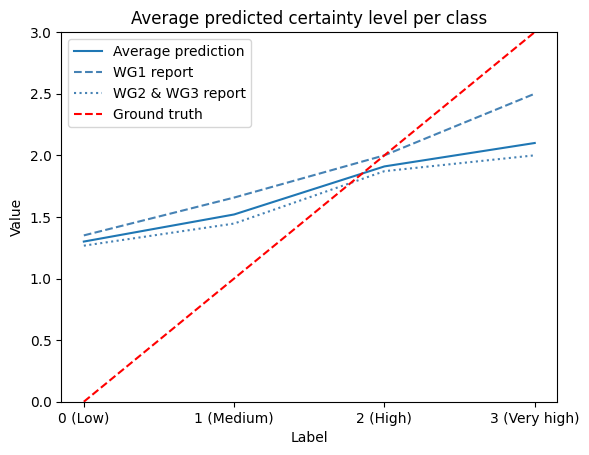

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='Average prediction')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted certainty level per class")
plt.xlabel("Label")
plt.ylabel("Value")

# Show the legend
plt.legend()

# Show the plot
plt.show()